In [1]:
!pip install pygraphviz

fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pickle

from src.models import HLGC
from src.data import Newsgroups

In [3]:
#data = pickle.load(open('data/cifar100-resnet18.pickle', 'rb'))
data = pickle.load(open('data/20newsgroups.pickle', 'rb'))

In [4]:
hparams = {
    'n_features' : len(data['train']['features'][0]),
    'hidden_dim' : 128,
    'latent_dims' : [50, 50, 50, 50, 50],
    'batch_size' : 32,
    'lr' : 0.001,
    'dropout' : 0.5,
    'n_epochs' : 25,
    'early_stopping_epochs' : 5,
    'latent_loss_weight' : 1.0,
    'recon_loss_weight' : 1.0,
    'l1_lambda' : 0.001, 
    'val_split' : 0.1, 
    'display_interval' : 200
}

In [6]:
model = HLGC(
    len(data['flat_label_dict']), hparams['n_features'], hparams['latent_dims'], hidden_dim=hparams['hidden_dim'], 
    dropout_rate=hparams['dropout'], batch_size=hparams['batch_size'], lr=hparams['lr'], 
    n_epochs=hparams['n_epochs'], class_weights=data['class_weights'], recon_loss_weight=hparams['recon_loss_weight'], 
    latent_loss_weight=hparams['latent_loss_weight'], 
    l1_lambda=hparams['l1_lambda'], display_interval=hparams['display_interval'], 
    early_stopping_epochs=hparams['early_stopping_epochs'], label_dict=data['flat_label_dict']
)

No validation data provided, using 10.0% of train data
[0,     1] loss - (total : 13.929319, clf : 2.998593, support : 3.001146, recon : 3.902518, latent : 3.003935), acc - (clf : 0.031250, recon : 0.037500)
[0,   200] loss - (total : 5.734340, clf : 1.786832, support : 1.627415, recon : 0.808138, latent : 1.380358), acc - (clf : 0.843750, recon : 0.556250)
[ Eval ] loss - (total : 4.870310, clf : 1.244730, support : 1.403042, recon : 0.639979, latent : 1.417449), acc - (clf : 0.858657, recon : 0.640106)
alt.atheism : [4, 10, 15, 17, 14]
talk.politics.guns : [4, 10, 15, 17, 14]
talk.politics.misc : [4, 10, 15, 17, 14]
-----
comp.graphics : [13, 38, 18, 33, 33]
comp.os.ms-windows.misc : [13, 38, 49, 30, 8]
comp.sys.ibm.pc.hardware : [13, 38, 18, 30, 8]
comp.sys.mac.hardware : [13, 38, 18, 30, 33]
comp.windows.x : [13, 38, 18, 33, 8]
rec.sport.hockey : [13, 8, 18, 30, 8]
-----
rec.motorcycles : [20, 17, 49, 30, 8]
sci.electronics : [20, 38, 49, 30, 33]
sci.med : [20, 10, 15, 17, 14]
----

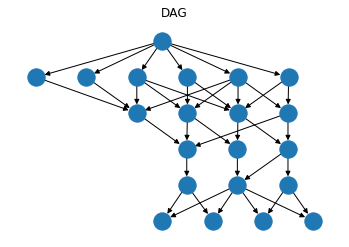

[1,   400] loss - (total : 4.043478, clf : 0.858320, support : 1.078789, recon : 0.563756, latent : 1.360473), acc - (clf : 1.000000, recon : 0.631250)
[1,   600] loss - (total : 3.124478, clf : 0.691332, support : 0.910395, recon : 0.469417, latent : 0.867888), acc - (clf : 0.906250, recon : 0.712500)
[ Eval ] loss - (total : 2.928260, clf : 0.631346, support : 0.870577, recon : 0.440485, latent : 0.802416), acc - (clf : 0.889576, recon : 0.776148)
alt.atheism : [4, 10, 15, 17, 14]
comp.sys.ibm.pc.hardware : [4, 38, 18, 30, 8]
talk.politics.guns : [4, 17, 49, 2, 16]
-----
comp.graphics : [13, 38, 49, 33, 14]
comp.os.ms-windows.misc : [13, 38, 18, 33, 33]
comp.windows.x : [13, 38, 18, 30, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
sci.med : [22, 10, 15, 17, 16]
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 17, 16]
-----
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 14]
sci.electronics : [26, 38, 49, 30, 16]
-----
comp.sys.m

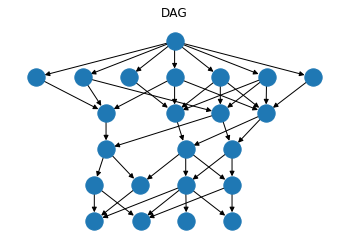

[2,   800] loss - (total : 1.318657, clf : 0.240241, support : 0.350086, recon : 0.249088, latent : 0.291049), acc - (clf : 1.000000, recon : 0.818750)
[ Eval ] loss - (total : 2.232668, clf : 0.438977, support : 0.680807, recon : 0.356394, latent : 0.582151), acc - (clf : 0.904594, recon : 0.858127)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
talk.religion.misc : [4, 10, 15, 17, 14]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.os.ms-windows.misc : [13, 38, 18, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 33]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
-----
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.forsale : [30, 38, 18, 30, 8]
rec.sport.hockey : [30, 8, 18, 30, 14]
sci.electronics : [30, 38, 49, 30, 8]
sci.space : [30, 17, 49, 30, 8]
-----
rec.motor

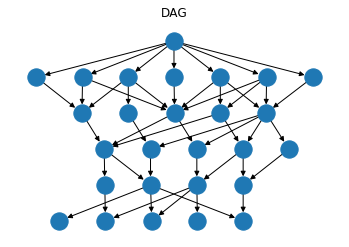

[3,  1000] loss - (total : 1.061514, clf : 0.177409, support : 0.229057, recon : 0.332260, latent : 0.149143), acc - (clf : 0.968750, recon : 0.893750)
[3,  1200] loss - (total : 1.086435, clf : 0.156641, support : 0.258257, recon : 0.238831, latent : 0.271317), acc - (clf : 0.968750, recon : 0.912500)
[ Eval ] loss - (total : 2.020287, clf : 0.360937, support : 0.632942, recon : 0.289190, latent : 0.579890), acc - (clf : 0.904594, recon : 0.889046)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
talk.religion.misc : [4, 10, 15, 17, 14]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.fo

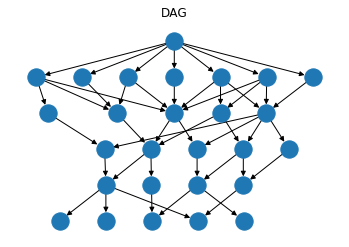

[4,  1400] loss - (total : 0.801178, clf : 0.110359, support : 0.055625, recon : 0.130970, latent : 0.355034), acc - (clf : 0.968750, recon : 0.937500)
[ Eval ] loss - (total : 1.953873, clf : 0.323839, support : 0.634986, recon : 0.322042, latent : 0.535557), acc - (clf : 0.906360, recon : 0.905124)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 5]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 5]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 16]
-----
misc.forsale : [30, 38, 18, 30, 16]
rec.sport.hockey : [30, 8, 18, 30, 33]
sci.electronics : [30, 38, 49, 30, 8]
sci.space : [30, 17, 7, 30, 8]
-----
rec.motor

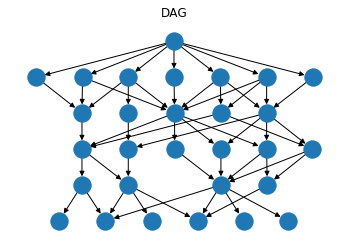

[5,  1600] loss - (total : 0.493546, clf : 0.033334, support : 0.087823, recon : 0.209052, latent : 0.026437), acc - (clf : 1.000000, recon : 0.906250)
[5,  1800] loss - (total : 0.331386, clf : 0.026363, support : 0.036511, recon : 0.133385, latent : 0.011512), acc - (clf : 1.000000, recon : 0.956250)
[ Eval ] loss - (total : 1.891337, clf : 0.308761, support : 0.620879, recon : 0.294279, latent : 0.547841), acc - (clf : 0.907244, recon : 0.925972)
alt.atheism : [4, 10, 15, 17, 14]
comp.sys.mac.hardware : [4, 38, 18, 30, 8]
talk.politics.guns : [4, 17, 15, 2, 16]
talk.religion.misc : [4, 10, 15, 2, 27]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.windows.x : [13, 38, 11, 17, 14]
sci.med : [13, 39, 11, 17, 33]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 16]
-----
misc.for

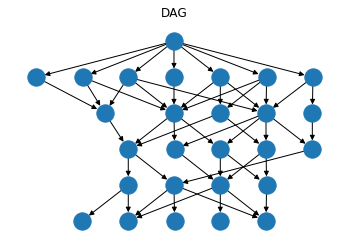

[6,  2000] loss - (total : 0.199906, clf : 0.017111, support : 0.021547, recon : 0.040571, latent : 0.006341), acc - (clf : 1.000000, recon : 0.962500)
[6,  2200] loss - (total : 0.376382, clf : 0.041065, support : 0.086152, recon : 0.104569, latent : 0.039373), acc - (clf : 0.968750, recon : 0.968750)
[ Eval ] loss - (total : 1.941688, clf : 0.312606, support : 0.685976, recon : 0.269512, latent : 0.570620), acc - (clf : 0.912544, recon : 0.936042)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
comp.os.ms-windows.misc : [30, 38, 18, 33, 33]
misc.fo

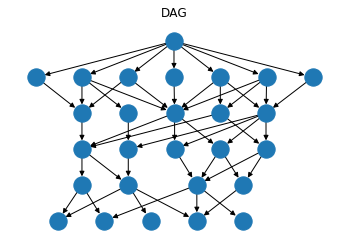

[7,  2400] loss - (total : 0.131450, clf : 0.008629, support : 0.015982, recon : 0.007075, latent : 0.004554), acc - (clf : 1.000000, recon : 0.993750)
[ Eval ] loss - (total : 2.112766, clf : 0.326943, support : 0.710469, recon : 0.355135, latent : 0.629997), acc - (clf : 0.911661, recon : 0.934099)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 5]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.forsale : [30, 38, 18, 0, 16]
rec.sport.hockey : [30, 8, 18, 30, 33]
sci.electronics : [30, 38, 49, 30, 8]
sci.space : [30, 17, 7, 30, 8]
-----
rec.motorcy

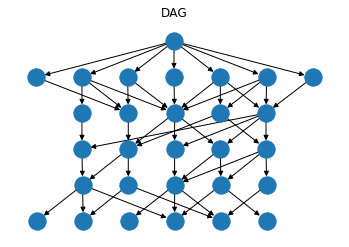

[8,  2600] loss - (total : 0.115989, clf : 0.003160, support : 0.014086, recon : 0.007654, latent : 0.004417), acc - (clf : 1.000000, recon : 1.000000)
[8,  2800] loss - (total : 0.126102, clf : 0.000989, support : 0.011438, recon : 0.033255, latent : 0.001535), acc - (clf : 1.000000, recon : 0.993750)
[ Eval ] loss - (total : 2.133169, clf : 0.345791, support : 0.745801, recon : 0.272527, latent : 0.692566), acc - (clf : 0.915194, recon : 0.950707)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.fo

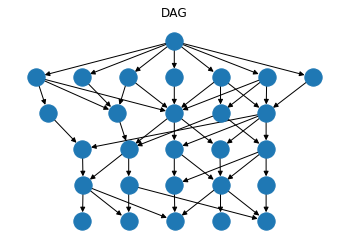

[9,  3000] loss - (total : 0.087943, clf : 0.000419, support : 0.010121, recon : 0.003320, latent : 0.000954), acc - (clf : 1.000000, recon : 1.000000)
[ Eval ] loss - (total : 2.180498, clf : 0.372943, support : 0.728929, recon : 0.313087, latent : 0.698718), acc - (clf : 0.916078, recon : 0.953357)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.forsale : [30, 38, 18, 0, 16]
rec.sport.hockey : [30, 8, 18, 30, 33]
sci.electronics : [30, 38, 49, 30, 8]
sci.space : [30, 17, 7, 30, 8]
-----
rec.motorc

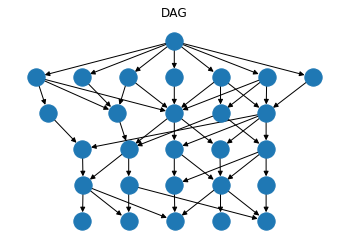

[10,  3200] loss - (total : 0.081142, clf : 0.000145, support : 0.009592, recon : 0.004032, latent : 0.000625), acc - (clf : 1.000000, recon : 0.993750)
[10,  3400] loss - (total : 0.072053, clf : 0.000291, support : 0.008294, recon : 0.001648, latent : 0.000378), acc - (clf : 1.000000, recon : 0.993750)
[ Eval ] loss - (total : 2.389765, clf : 0.402735, support : 0.754629, recon : 0.396434, latent : 0.775749), acc - (clf : 0.911661, recon : 0.942403)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.

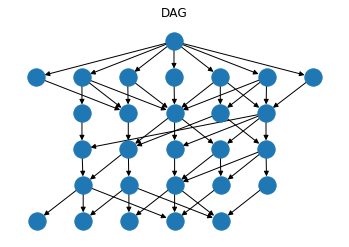

[11,  3600] loss - (total : 0.065535, clf : 0.000092, support : 0.007645, recon : 0.001411, latent : 0.000260), acc - (clf : 1.000000, recon : 1.000000)
[11,  3800] loss - (total : 0.062183, clf : 0.000155, support : 0.008119, recon : 0.000831, latent : 0.000402), acc - (clf : 1.000000, recon : 1.000000)
[ Eval ] loss - (total : 2.350781, clf : 0.425194, support : 0.775336, recon : 0.388939, latent : 0.709988), acc - (clf : 0.912544, recon : 0.957597)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.

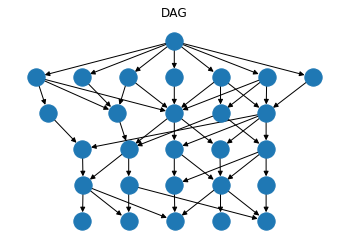

[12,  4000] loss - (total : 0.064409, clf : 0.001296, support : 0.008697, recon : 0.001056, latent : 0.002217), acc - (clf : 1.000000, recon : 0.993750)
[ Eval ] loss - (total : 2.490274, clf : 0.458106, support : 0.835855, recon : 0.322800, latent : 0.826255), acc - (clf : 0.909894, recon : 0.964488)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.forsale : [30, 38, 18, 0, 16]
rec.sport.hockey : [30, 8, 18, 30, 33]
sci.electronics : [30, 38, 49, 30, 8]
sci.space : [30, 17, 7, 30, 8]
-----
rec.motor

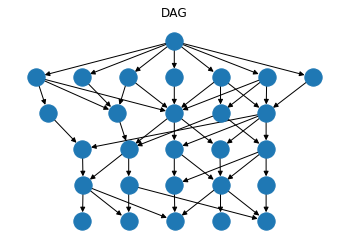

[13,  4200] loss - (total : 0.051395, clf : 0.000011, support : 0.005763, recon : 0.000441, latent : 0.000116), acc - (clf : 1.000000, recon : 1.000000)
[13,  4400] loss - (total : 0.055320, clf : 0.000261, support : 0.006938, recon : 0.001001, latent : 0.000168), acc - (clf : 1.000000, recon : 1.000000)
[ Eval ] loss - (total : 2.497695, clf : 0.500688, support : 0.850924, recon : 0.333996, latent : 0.769047), acc - (clf : 0.910777, recon : 0.960071)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.

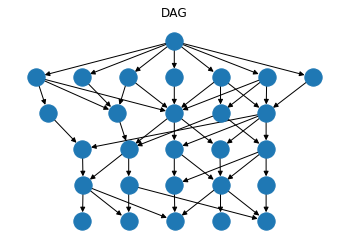

[14,  4600] loss - (total : 0.047849, clf : 0.000007, support : 0.004205, recon : 0.002787, latent : 0.000093), acc - (clf : 1.000000, recon : 1.000000)
[ Eval ] loss - (total : 2.553726, clf : 0.528220, support : 0.857542, recon : 0.317640, latent : 0.811388), acc - (clf : 0.910777, recon : 0.966078)
alt.atheism : [4, 10, 15, 17, 14]
sci.med : [4, 39, 11, 17, 33]
talk.politics.guns : [4, 17, 15, 2, 16]
-----
comp.graphics : [13, 38, 7, 33, 33]
comp.sys.mac.hardware : [13, 38, 18, 30, 8]
comp.windows.x : [13, 38, 11, 17, 14]
-----
sci.crypt : [20, 17, 49, 30, 8]
-----
soc.religion.christian : [22, 10, 15, 17, 14]
talk.religion.misc : [22, 10, 15, 2, 27]
-----
comp.os.ms-windows.misc : [26, 38, 18, 33, 33]
comp.sys.ibm.pc.hardware : [26, 38, 18, 30, 8]
rec.autos : [26, 17, 49, 30, 16]
rec.sport.baseball : [26, 8, 15, 17, 27]
-----
misc.forsale : [30, 38, 18, 0, 16]
rec.sport.hockey : [30, 8, 18, 30, 33]
sci.electronics : [30, 38, 49, 30, 8]
sci.space : [30, 17, 7, 30, 8]
-----
rec.motor

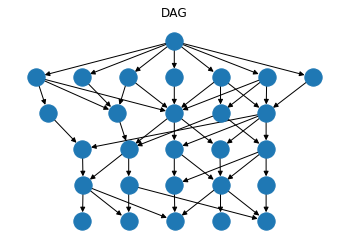

Training complete!


In [7]:
model.fit(data['train']['features'], data['train']['flat_labels'], save_dir='train_results/20newsgroups')